### Azure AI評価



1. ライブラリのインポート

In [1]:
import os
import re

from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from dotenv import load_dotenv
import pandas as pd
from openai import AzureOpenAI
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.models import VectorizedQuery
import json
from azure.cosmos import PartitionKey
from azure.cosmos.cosmos_client import CosmosClient
from datetime import datetime

2. 環境変数の読み込み

In [2]:
# Load environment variables
load_dotenv(override=True)

AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_MODEL = os.getenv("AZURE_OPENAI_CHAT_MODEL")
AZURE_OPENAI_EMBED_MODEL = os.getenv("AZURE_OPENAI_EMBED_MODEL")
AZURE_OPENAI_CHAT_MAX_TOKENS = int(os.getenv("AZURE_OPENAI_CHAT_MAX_TOKENS", "1000"))

# Azure OpenAI Service の情報を環境変数から取得する
client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION")
)


# Azure AI Search の情報を環境変数から取得する
AI_SEARCH_ENDPOINT = os.getenv("AI_SEARCH_ENDPOINT")
AI_SEARCH_KEY = os.getenv("AI_SEARCH_KEY")
AI_SEARCH_API_VERSION = os.getenv("AI_SEARCH_API_VERSION", "2023-10-01-Preview")
AI_SEARCH_INDEX_NAME = os.getenv("AI_SEARCH_INDEX_NAME")
AI_SEACH_SEMANTIC = os.getenv("AI_SEACH_SEMANTIC")

SUBSCRIPTION_ID = os.getenv("SUBSCRIPTION_ID")
RESOURCE_GROUP_NAME = os.getenv("RESOURCE_GROUP_NAME")
PROJECT_NAME = os.getenv("PROJECT_NAME")

COSMOS_CONNECTION_STRING = os.getenv("COSMOS_CONNECTION_STRING")
COSMOS_DB_NAME = os.getenv("COSMOS_DB_NAME")
COSMOS_CONTAINER_NAME_CHAT = os.getenv("COSMOS_CONTAINER_NAME_CHAT")

# 検索結果の上位何件を取得するか
TOP_K = 5

# 生成回答を追加したQnAペアを保存するリスト
augmented_qna_pairs = []  

3. 評価データの読み込み
    
・CosmosDBのログからの評価データ作成

In [3]:
cosmos_client = CosmosClient.from_connection_string(COSMOS_CONNECTION_STRING)
database = cosmos_client.get_database_client(COSMOS_DB_NAME)
database.create_container_if_not_exists(
    id=COSMOS_CONTAINER_NAME_CHAT,
    partition_key=PartitionKey(path=f"/id"),
)
container = database.get_container_client(COSMOS_CONTAINER_NAME_CHAT)

query = 'SELECT VALUE { "query": c.question, "response": c.answer, "context": c.context, "ground_truth": "" } FROM ragchat c where c.role="eval"'
items = list(container.query_items(
    query=query,
    enable_cross_partition_query=True
))

import jsonlines

# 現在の日時を取得してフォーマット
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

# JSONL形式でファイルに書き込む（UTF-8エンコーディング）
with open(f'./eval/output/eval_rag_{current_time}.jsonl', mode='w', encoding='utf-8') as f:
    writer = jsonlines.Writer(f, dumps=lambda obj: json.dumps(obj, ensure_ascii=False))
    writer.write_all(items)


# 例として、'qna_pairs.jsonl'というファイルから読み込む
qna_pairs = items


### AI Eval

4. 評価の実行

In [8]:
from azure.ai.evaluation import RelevanceEvaluator, CoherenceEvaluator, GroundednessEvaluator, FluencyEvaluator, SimilarityEvaluator, QAEvaluator 

azure_ai_project = { 
    "subscription_id": SUBSCRIPTION_ID,
    "resource_group_name": RESOURCE_GROUP_NAME,
    "project_name": PROJECT_NAME
}

env_var = {
    "gpt-4o": {
        "endpoint": f"{AZURE_OPENAI_ENDPOINT}/deployments/{AZURE_OPENAI_CHAT_MODEL}/chat/completions?api-version=2024-06-01",
        "key": f"{AZURE_OPENAI_API_KEY}",
    },
}

# Initialize Azure OpenAI Connection with your environment variables
model_config = {
    "azure_endpoint": AZURE_OPENAI_ENDPOINT,
    "api_key": AZURE_OPENAI_API_KEY,
    "azure_deployment": AZURE_OPENAI_CHAT_MODEL,
    "api_version": "2024-06-01",
    "type": "azure_openai",
}

results=[]

# jsonlファイルからquery, response, context, ground_truthを読み込み、評価を行う
for augmented_qna in qna_pairs:
    query = augmented_qna['query']
    response = augmented_qna['response']
    context = augmented_qna['context']

    relevance_evaluator = RelevanceEvaluator(model_config)
    coherence_evaluator = CoherenceEvaluator(model_config)
    groundedness_evaluator = GroundednessEvaluator(model_config)
    fluency_evaluator = FluencyEvaluator(model_config)
    #eval_fn = QAEvaluator(model_config)

    resultRelevance = relevance_evaluator(
        query=query,
        response=response,
        context=context,
    )

    resultCoherence= coherence_evaluator(
        query=query,
        response=response,
    )

    resultGroundness = groundedness_evaluator(
        response=response,
        context=context,
    )

    resultFuluency = fluency_evaluator(
        query=query,
        response=response,
    )
   
    # result結果にquery, response, context, ground_truthを追記
    result = {
        'gpt_groundedness': resultGroundness['gpt_groundedness'],
        'gpt_relevance': resultRelevance['gpt_relevance'],
        'gpt_coherence': resultCoherence['gpt_coherence'],
        'gpt_fluency': resultFuluency['gpt_fluency'],
        'query': query,
        'response': response,
        'context': context,
    }

    #results配列にresult結果を追記
    results.append(result)

    print(result)

# 現在の日時を取得してフォーマット
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

# ファイル名に日時情報を追加して保存
output_file_path = f'./eval/output/eval_results_{current_time}.jsonl'
with open(output_file_path, 'w', encoding='utf-8') as f:
    for result in results:
        json_line = json.dumps(result, ensure_ascii=False)
        f.write(json_line + '\n')

{'gpt_relevance': 5.0}
{'gpt_groundedness': 5.0, 'gpt_relevance': 5.0, 'gpt_coherence': 5.0, 'gpt_fluency': 5.0, 'query': 'GPTの活用について教えてください。', 'response': 'GPTの活用について、以下の情報を提供します。\n\n1. **自然言語におけるユースケース**:\n   - **文章の添削、校正**: 文法ミスだけでなく、内容の改善点まで指摘します。\n   - **文章や概念の要約**: 文字数を指定して要約が可能です。\n   - **壁打ち、ブレインストーミング**: 考えの抜けている点を指摘し、AIと人間で会話しながらアイディエーションを行います。\n   - **リサーチ、論点の洗い出し**: 要点の説明やディベート風に論点を洗い出し、表形式で比較表を作成します。\n   - **アイデアの提案**: SEO対策したタイトルやキーワード形成、広告文の自動生成、結婚式のスピーチのアウトライン作成、人気の出るブログの内容案の提案などが可能です。\n\n   これらのタスクは、ChatGPTの卓越したコミュニケーション精度と圧倒的な知識量により、以前ではできなかったことまで可能にしています。[20230217_AIの進化と日本の戦略_松尾研.pdf-5]\n\n2. **教育分野での活用**:\n   - **宿題の利用禁止**: ニューヨークやシアトル州の公立学校では、ChatGPTの宿題への利用を禁止しています。\n   - **教育ツールとしての活用**: 一部の教育機関では、ChatGPTを使って文章を作成する練習をすることで、自然な英語表現を身につけることを目指しています。[20230217_AIの進化と日本の戦略_松尾研.pdf-5]\n\n3. **科学論文の執筆**:\n   - **執筆の禁止**: ICMLなどの学会では、ChatGPTを活用して科学論文を執筆することを禁止しています。\n   - **編集や推敲の活用**: 文章の編集や推敲にChatGPTを活用することは問題ないとされています。[20230217_AIの進化と日本の戦略_松尾研.pdf-5]\n\n4. **検索エンジンへの統

5. 評価結果の可視化

   gpt_coherence  gpt_relevance  gpt_fluency  gpt_groundedness
0            5.0            5.0          5.0               5.0
1            5.0            5.0          5.0               5.0
2            5.0            5.0          5.0               5.0
3            5.0            4.0          5.0               5.0
4            5.0            5.0          5.0               5.0


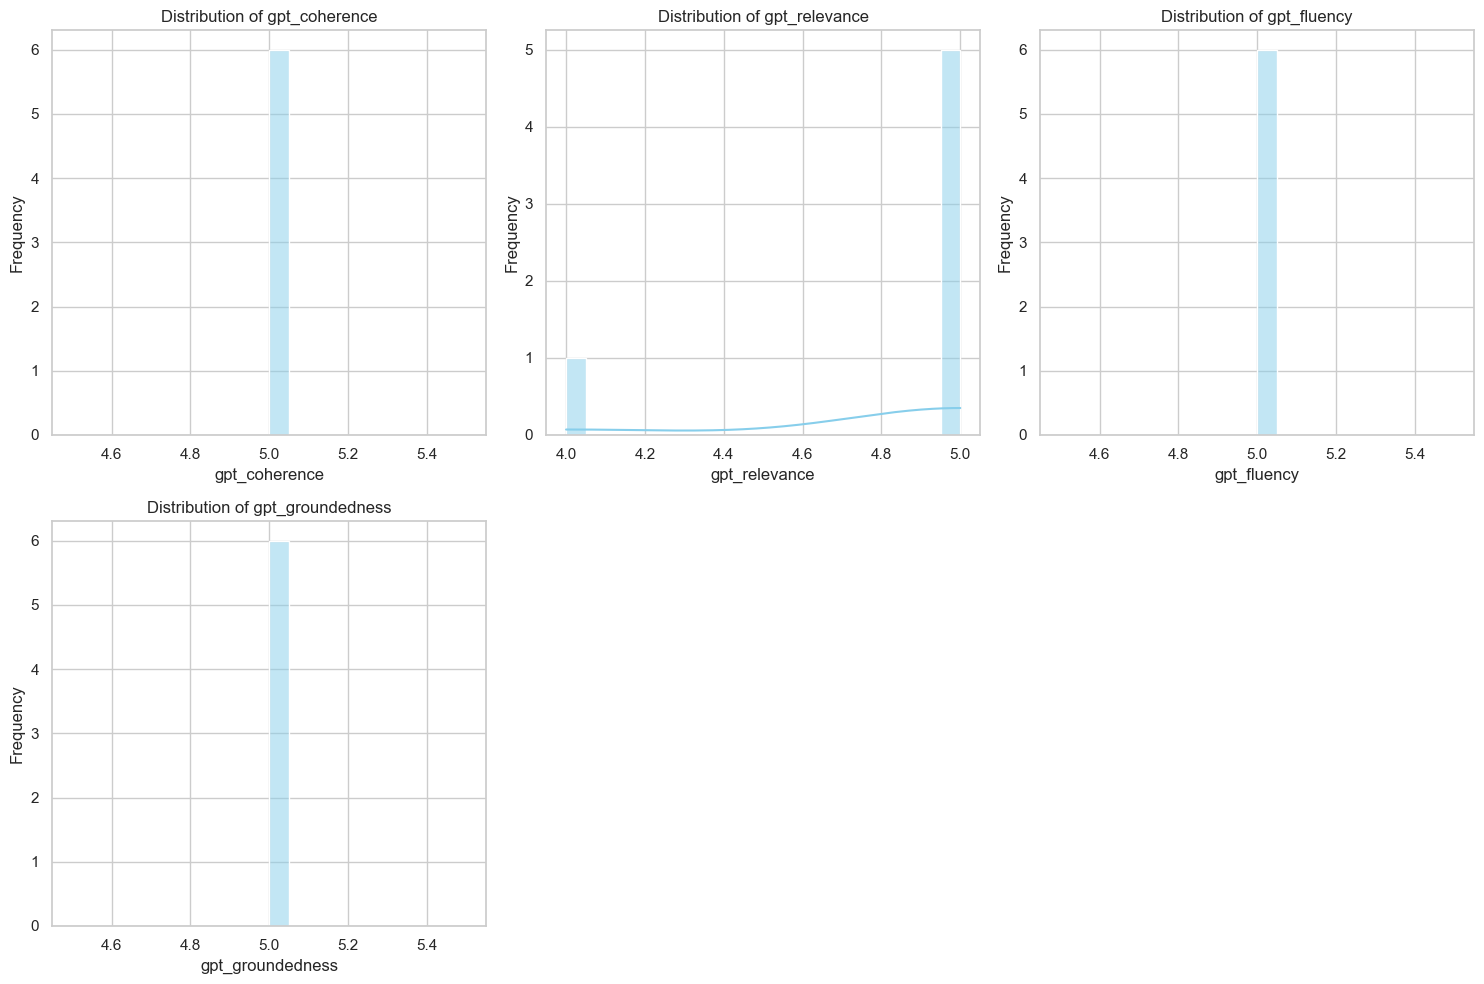

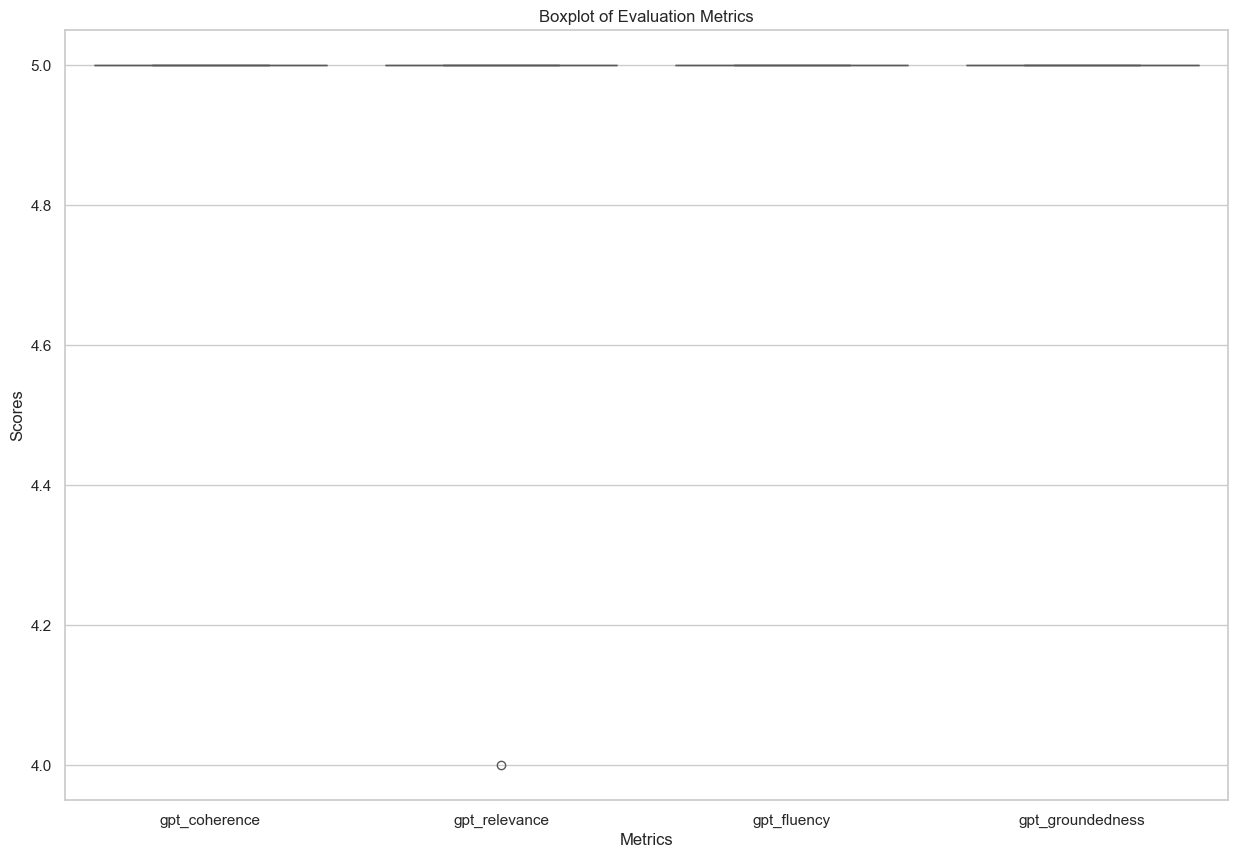

C:\Users\hnagasawa\AppData\Local\Temp\ipykernel_26164\262613683.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=mean_scores.index, y=mean_scores.values, palette='viridis')


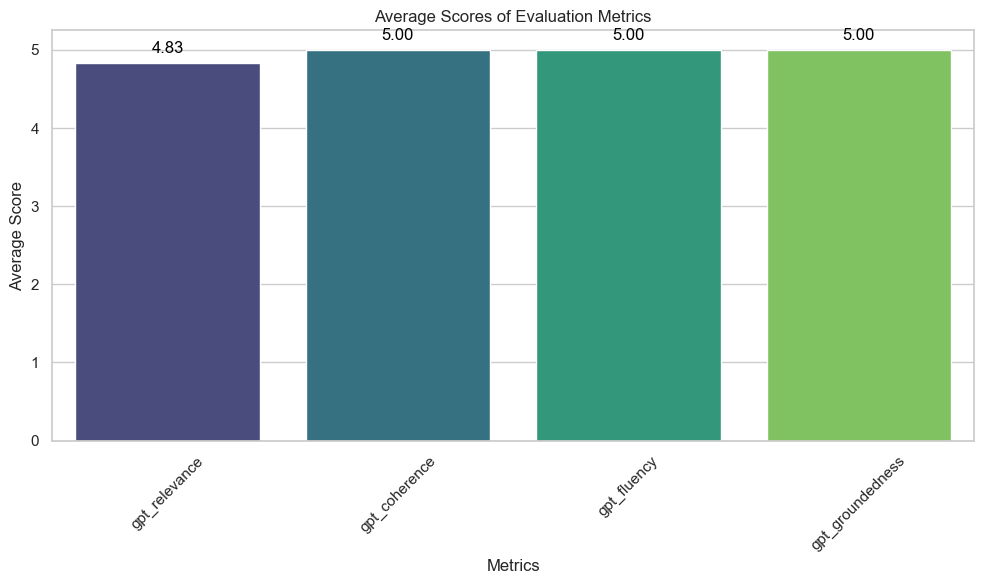

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# resultsをpandasのDataFrameに変換
df = pd.DataFrame(results)

# df内のf1_score,gpt_coherence,gpt_relevance,gpt_fluency,gpt_similarity,gpt_groundednessの項目のみを抽出
metrics = ['gpt_coherence', 'gpt_relevance', 'gpt_fluency', 'gpt_groundedness']

# 指標データのみを抽出
metrics_df = df[metrics]

# データの確認
print(metrics_df.head())
# グラフのスタイル設定
sns.set(style="whitegrid")

# 1. 各評価指標のヒストグラム
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.histplot(metrics_df[metric], bins=20, kde=True, color='skyblue')
    plt.title(f'Distribution of {metric}')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 2. 各評価指標のボックスプロット
plt.figure(figsize=(15, 10))
sns.boxplot(data=metrics_df, palette='Set2')
plt.title('Boxplot of Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.show()

# 3. 評価指標ごとの平均値の棒グラフに数値ラベルを追加
mean_scores = metrics_df.mean().sort_values()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=mean_scores.index, y=mean_scores.values, palette='viridis')
plt.title('Average Scores of Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Average Score')
plt.xticks(rotation=45)

# 各バーの上に平均値の数値を表示
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

